In [18]:
import os

api_token = os.getenv('NEPTUNE_API_TOKEN')

In [20]:
import neptune
import numpy as np
import pandas as pd

project_name = "ACFRmarine/ALDI-DOAD"

project = neptune.init_project(
    project=project_name,
    mode="read-only",
    api_token=api_token,

)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/


In [21]:
def is_in_run(column_name, run):
    names = column_name.split('/')
    layer = run.get_structure()
    for n in names:
        if n not in layer:
            return False
        layer = layer[n]
    return True

def get_max_eval_for_metric_from_run(run_id, metric_name, api_token, project_name, eval_name="training/metrics/bbox/AP50"):
    run = neptune.init_run(with_id=run_id, mode="read-only",
                           api_token=api_token,
                           project=project_name)
    if is_in_run(metric_name, run) and is_in_run(eval_name, run):
        step = run[metric_name].fetch_values()['value'].argmax()
        eval_data = run[eval_name].fetch_values()
        return eval_data[eval_data['step'] == step]['value'].iloc[0]
    else:
        return None

def get_max_AP50_from_id(run_id):
    return get_max_eval_for_metric_from_run(run_id, 'training/metrics/bbox/AP50',
                            api_token=api_token, project_name=project_name)

# Summary info for SAOD

In [22]:
runs_table_df = project.fetch_runs_table(query='(`sys/group_tags`:stringSet CONTAINS "SAOD8")').to_pandas()
runs_table_df = runs_table_df[runs_table_df['sys/failed'] == False]
df = runs_table_df

In [23]:


def get_method(group_tags):
    if "WTWSSW_i_str" in group_tags:
        return "Strong Loss"
    elif "WTWSSW_i_weak" in group_tags:
        return "Weak Loss"
    elif "WTWSSW_i" in group_tags:
        return "Our method"
    elif "ORACLE" in group_tags:
        return "Fully Supervised"
    else:
        "Not sure"


import ast
def split_list_names(list_string):
    #s = "['loose_redcup17648_train_og_only', 'squidle_redcup_train_labelled']"
    # Safely evaluate the string to a Python list
    str_list = ast.literal_eval(list_string)
    # Split each string by underscore
    #token_lists = [item.split('_') for item in str_list]
    return str_list


def add_dataset_name(df, column_name):
    # eg [\'loose_redcup17648_train_og_only\']
    df[f'parsed_{column_name}'] = df[column_name].apply(ast.literal_eval)
    df[f'first_{column_name}'] = df[f'parsed_{column_name}'].apply(lambda x: x[0] if len(x) > 0 else None)
    df['dataset'] = df[f'first_{column_name}'].apply(get_dataset_name)
    
import re

def extract_semi_code(s):
    if isinstance(s, str):
        match = re.search(r'SEMI\{(\d+)\}', s)
        return int(match.group(1)) if match else None
    return None

    

def get_dataset_name(first_dataset_col):
    if first_dataset_col.startswith("squidle_"):
        if first_dataset_col.endswith("_train_sparse"):
            return "Bbox Sparse"
        elif first_dataset_col.endswith("_train"):
            return "Bbox All"
    elif first_dataset_col.startswith("loose_"):
        if "17714" in first_dataset_col or "17711" in first_dataset_col:
            ds_name = "Point Few (bbox)"
        elif "17631" in first_dataset_col or "17648" in first_dataset_col:
            ds_name = "Point Few (mass)"
        elif "17630" in first_dataset_col or "17647" in first_dataset_col:
            ds_name = "Point All (mass)"
        if first_dataset_col.endswith("_og_only"):
            return ds_name
        elif first_dataset_col.endswith("_cropped_only"):
            return f"{ds_name} Cropped"
    return "Unknown"

def get_max_from_run(run_id, column_name, api_token, project_name, other_cols=[]):
    run = neptune.init_run(with_id=run_id, mode="read-only",
                           api_token=api_token,
                           project=project_name)
    if is_in_run(column_name, run):
        return run[column_name].fetch_values()['value'].max() # Get iteration number so we can get AR at same point
    else:
        return None

def get_max_AP50_from_id(run_id):
    return get_max_from_run(run_id, 'training/metrics/bbox/AP50',
                            api_token=api_token, project_name=project_name)



In [24]:
run_id = 'AL-1534'
run = neptune.init_run(with_id=run_id, mode="read-only",
                       api_token=api_token,
                       project=project_name)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1534


In [25]:
AP50_df = run['training/metrics/bbox/AP50'].fetch_values()
max_value = AP50_df['value'].max()
max_step = AP50_df.loc[AP50_df['value'].idxmax()]['step']

AR50at10_df = run['training/metrics/bbox/AR50@10'].fetch_values()
AR50at10_max_value = AR50at10_df['value'].max()
AR50at10_max_step = AR50at10_df.loc[AR50at10_df['value'].idxmax()]['step']




## Add column data

In [26]:
df['species'] = df['training/config/DATASETS/TEST'].apply(lambda x: '2Redcup' if x == "(\'squidle_redcup_test\',)" else '1Urchin')
df['method'] = df['sys/group_tags'].apply(get_method)
add_dataset_name(df, 'training/config/DATASETS/TRAIN')
df['last_AP50'] = df['training/metrics/bbox/AP50']
df['last_AR50@10'] = df['training/metrics/bbox/AR50@10']
df['last_AR50@100'] = df['training/metrics/bbox/AR50@100']
df['Seed'] = df ['training/config/SEED']
df['lr'] = df['training/config/SOLVER/BASE_LR']
df['semi_code'] = df['sys/group_tags'].apply(extract_semi_code)
print(set(df['dataset']))

{'Point Few (mass) Cropped', 'Point Few (mass)', 'Unknown', 'Point Few (bbox)', 'Bbox All', 'Bbox Sparse', 'Point Few (bbox) Cropped'}


## Find Max AP50

In [27]:
df['max_AP50'] = df['sys/id'].apply(get_max_AP50_from_id)

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1598
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1597
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1596
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1595
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1594
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1593
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1592
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1591
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/

In [28]:

def mean_with_nan(group):
    return np.nan if group.isna().any() else group.mean()

def std_with_nan(group):
    return np.nan if group.isna().any() else group.std()



## df_summary and df_grouped - main results tables

In [29]:
# Replace 'group_col1', 'group_col2', 'group_col3' with your actual column names
df_summary = df[~df['semi_code'].notna()][['sys/id', 'lr', 'species', 'dataset', 'method', 'max_AP50', 'last_AP50', 'Seed', 'training/config/MODEL/WEIGHTS']]
df_summary = df_summary.sort_values(by=['species','dataset','method','Seed'])

In [30]:
group_columns = ['species', 'dataset', 'method', 'lr', 'training/config/MODEL/WEIGHTS']
df_grouped = df_summary.groupby(group_columns, dropna=False).agg(
    AP50_1max_mean=('max_AP50', mean_with_nan),
    AP50_1max_std=('max_AP50', std_with_nan),
    AP50_2last_mean=('last_AP50', mean_with_nan),
    AP50_2last_std=('last_AP50', std_with_nan),
    #AR50_10_3last_mean=('last_AR50@10', mean_with_nan),
    #AR50_10_3last_std=('last_AR50@100', std_with_nan),
    #AR50_100_4last_mean=('last_AR50@100', mean_with_nan),
    #AR50_100_4last_std=('last_AR50@100', std_with_nan),
    count=('max_AP50', 'size')  # or use 'count' if you want to exclude NaNs
).reset_index()
#df_grouped = df_grouped.round({'AP50_1max_mean': 1, 'AP50_1max_std': 1, 'AP50_2last_mean': 1, 'AP50_2last_std': 1, 'AR50_10_3last_mean': 1, 'AR50_10_3last_std': 1, 'AR50_100_4last_mean': 1, 'AR50_100_4last_std': 1})
df_grouped = df_grouped.round({'AP50_1max_mean': 1, 'AP50_1max_std': 1, 'AP50_2last_mean': 1, 'AP50_2last_std': 1})

In [31]:
print(df_grouped.to_string(index=False))
df_melted = pd.pivot(df_grouped, index=['lr','training/config/MODEL/WEIGHTS', 'dataset', 'method' ], columns='species', values=['AP50_1max_mean', 'AP50_1max_std',
                                                                                          'AP50_2last_mean', 'AP50_2last_std']) #,  'AR50_10_3last_mean', 'AR50_10_3last_std',  'AR50_100_4last_mean', 'AR50_100_4last_std'])
df_melted.columns = df_melted.columns.reorder_levels([1, 0])
df_melted = df_melted.sort_index(axis=1)
print(df_melted.to_string())


species                  dataset           method   lr                 training/config/MODEL/WEIGHTS  AP50_1max_mean  AP50_1max_std  AP50_2last_mean  AP50_2last_std  count
1Urchin                 Bbox All Fully Supervised 0.02                 models/model_final_f10217.pkl            95.4            0.4             92.2             0.5      3
1Urchin              Bbox Sparse       Our method 0.02                 models/model_final_f10217.pkl            51.6           37.8             50.7            36.4      3
1Urchin         Point Few (bbox)       Our method 0.02                 models/model_final_f10217.pkl            10.7           11.3              3.6             3.7      3
1Urchin Point Few (bbox) Cropped       Our method 0.02                 models/model_final_f10217.pkl            22.9            5.0              9.6             1.5      3
1Urchin         Point Few (mass)       Our method 0.02                 models/model_final_f10217.pkl            22.7            1.9         

## SEMI results
Filter out anything not Semi


In [32]:

semi_0 = df_summary.loc[(df_summary['species']=='2Redcup') & (df_summary['method'] == "Our method") & (df_summary['dataset']=="Point Few (bbox)") & (df_summary['lr']==0.02)].copy()
semi_0['semi_code'] = [0] * 3

semi_249 = df_summary.loc[(df_summary['species']=='2Redcup') & (df_summary['method'] == "Fully Supervised") & (df_summary['dataset']=="Bbox All") & (df_summary['lr']==0.02)].copy()
semi_249['semi_code'] = [249] * 3

In [33]:
df_semi = df[df['semi_code'].notna()][['sys/id', 'lr', 'species', 'dataset','semi_code', 'method', 'max_AP50', 'last_AP50', 'Seed']]
df_semi = df_semi.sort_values(by=['species','dataset','method','Seed'])
df_semi = pd.concat([df_semi, semi_0, semi_249], ignore_index=True)
group_columns = ['species', 'dataset', 'method', 'lr', 'semi_code']
df_semi_grouped = df_semi.groupby(group_columns, dropna=False).agg(
    AP50_1max_mean=('max_AP50', mean_with_nan),
    AP50_1max_std=('max_AP50', std_with_nan),
    AP50_2last_mean=('last_AP50', mean_with_nan),
    AP50_2last_std=('last_AP50', std_with_nan),
    #AR50_10_3last_mean=('last_AR50@10', mean_with_nan),
    #AR50_10_3last_std=('last_AR50@100', std_with_nan),
    #AR50_100_4last_mean=('last_AR50@100', mean_with_nan),
    #AR50_100_4last_std=('last_AR50@100', std_with_nan),
    count=('max_AP50', 'size')  # or use 'count' if you want to exclude NaNs
).reset_index()
#df_semi_grouped = df_semi_grouped.round({'AP50_1max_mean': 1, 'AP50_1max_std': 1, 'AP50_2last_mean': 1, 'AP50_2last_std': 1, 'AR50_10_3last_mean': 1, 'AR50_10_3last_std': 1, 'AR50_100_4last_mean': 1, 'AR50_100_4last_std': 1})
df_semi_grouped = df_semi_grouped.round({'AP50_1max_mean': 1, 'AP50_1max_std': 1, 'AP50_2last_mean': 1, 'AP50_2last_std': 1})

In [34]:
print(df_semi_grouped.to_string(index=False))
df_melted = pd.pivot(df_semi_grouped, index=['lr','semi_code', 'dataset', 'method' ], columns='species', values=['AP50_1max_mean', 'AP50_1max_std',
                                                                                          'AP50_2last_mean', 'AP50_2last_std']) #,  'AR50_10_3last_mean', 'AR50_10_3last_std',  'AR50_100_4last_mean', 'AR50_100_4last_std'])
df_melted.columns = df_melted.columns.reorder_levels([1, 0])
df_melted = df_melted.sort_index(axis=1)
print(df_melted.to_string())


species          dataset           method   lr  semi_code  AP50_1max_mean  AP50_1max_std  AP50_2last_mean  AP50_2last_std  count
2Redcup         Bbox All Fully Supervised 0.02      249.0            93.9            0.0             91.2             0.2      3
2Redcup Point Few (bbox)       Our method 0.02        0.0            60.5            8.9             51.2             7.8      3
2Redcup Point Few (bbox)       Our method 0.02       25.0            82.0            1.3             74.5             2.4      3
2Redcup Point Few (bbox)       Our method 0.02       50.0            84.3            0.5             74.7             3.9      3
2Redcup Point Few (bbox)       Our method 0.02      100.0            87.4            0.5             80.7             2.8      3
2Redcup Point Few (bbox)       Our method 0.02      200.0            89.2            0.3             82.6             2.7      3
species                                                 2Redcup                                  

/home/heather/.conda/envs/py310_torch/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/heather/.conda/envs/py310_torch/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


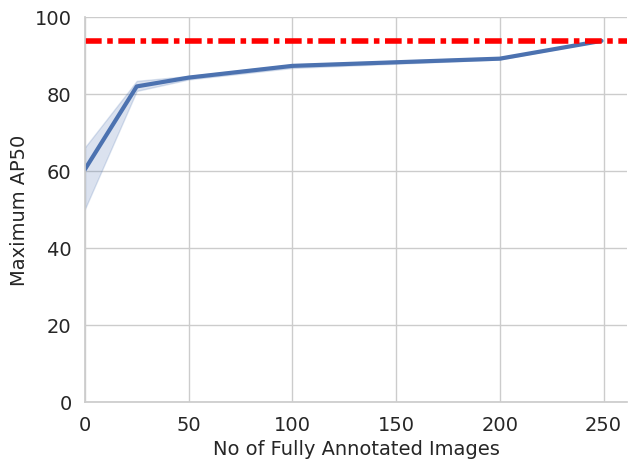

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Apply the default theme
sns.set_theme(style="whitegrid")
g = sns.relplot(
    data=df_semi, 
    x='semi_code', y='max_AP50', #col='Dataset', 
    #hue='Augmented with Synthetic Data', 
    kind='line', 
    markers=["o", "<", ">", "*"], 
    #style='Synthetic Data', 
    linewidth=3,
    aspect=1.4,
    height=5,
    facet_kws={'gridspec_kws': {'wspace': 0.05, 'hspace': 0.05}})
#g.set(xscale='log')

# Add titles and labels

# Define y-values for horizontal lines for each subplot
y_values = {'Redcup': 93.9}

# Add horizontal lines to each subplot
for ax, category in zip(g.axes.flat, y_values):
    ax.axhline(y=y_values[category], color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=4)
plt.ylim(0, 100)
plt.xlim(0, None)

g.set_axis_labels("No of Fully Annotated Images", "Maximum AP50", fontsize=14)
g.set_titles("{col_name}", size=14)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)


plt.show()
fig = g.fig
fig.savefig('semi_supervised_redcup_maxAP.jpg', dpi=200)

/home/heather/.conda/envs/py310_torch/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/heather/.conda/envs/py310_torch/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


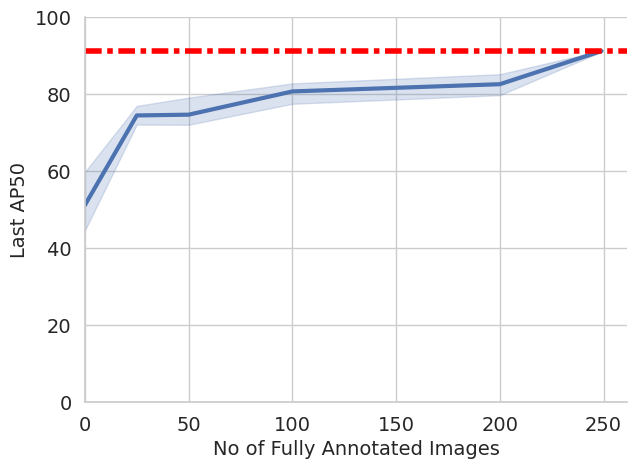

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Apply the default theme
sns.set_theme(style="whitegrid")
g = sns.relplot(
    data=df_semi, 
    x='semi_code', y='last_AP50', #col='Dataset', 
    #hue='Augmented with Synthetic Data', 
    kind='line', 
    markers=["o", "<", ">", "*"], 
    #style='Synthetic Data', 
    linewidth=3,
    aspect=1.4,
    height=5,
    facet_kws={'gridspec_kws': {'wspace': 0.05, 'hspace': 0.05}})
#g.set(xscale='log')

# Define y-values for horizontal lines for each subplot
y_values = {'Redcup': 91.2}

# Add horizontal lines to each subplot
for ax, category in zip(g.axes.flat, y_values):
    ax.axhline(y=y_values[category], color='red', linestyle=(0, (3, 1, 1, 1)), linewidth=4)
plt.ylim(0, 100)
plt.xlim(0, None)


g.set_axis_labels("No of Fully Annotated Images", "Last AP50", fontsize=14)
g.set_titles("{col_name}", size=14)
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

plt.show()
fig = g.fig
fig.savefig('semi_supervised_redcup_lastAP.jpg', dpi=200)

In [37]:
## Get CoStudent data

In [38]:
import pandas as pd
import re
import json
import numpy as np
from glob import glob

files = glob("../../CoStudent/summary/*.txt")
for f in files:
    with open(f, 'r') as file:
        line_data = []
        for line in file:
            line = line.replace('NaN', 'null')
            filename, json_str = line.split(":", 1)
            seed_match = re.search(r'_\d{7}_', filename)
            seed = seed_match.group().strip('_') if seed_match else None
            if seed is None:
                seed_match = re.search(r'_\d{7}/', filename)
                seed = seed_match.group().strip('_').strip('/') if seed_match else None 
            #print(seed, filename)
            if seed is not None:
                data = json.loads(json_str)
                data['seed'] = seed
                line_data.append(data)
        df = pd.DataFrame(line_data)
        print(f)
        if len(df) > 0:
            max_iter_idx = df.groupby('seed')['iteration'].idxmax()
            last_df = df.loc[max_iter_idx, ['seed', 'bbox/AP50']].copy()
            max_df = pd.DataFrame(df.groupby('seed')['bbox/AP50'].max())
            last_df = last_df.merge(max_df,left_on='seed', right_index=True, suffixes=('_last', '_max'))
            #print(last_df)
            print(f"${round(last_df['bbox/AP50_max'].mean(), 1)} \pm {round(last_df['bbox/AP50_max'].std(), 1)}$ & ${round(last_df['bbox/AP50_last'].mean(), 1)} \pm {round(last_df['bbox/AP50_last'].std(), 1)} $ %{len(last_df)}")


../../CoStudent/summary/fcos_costudent_redcup.txt
$49.5 \pm 0.1$ & $39.7 \pm 4.7 $ %2
../../CoStudent/summary/AP50_redcup_cropped_few_costudent.txt
$68.9 \pm 5.2$ & $51.2 \pm 0.9 $ %3
../../CoStudent/summary/AP50_urchin_og_gt_few_costudent.txt
$87.4 \pm 2.4$ & $83.7 \pm 0.5 $ %3
../../CoStudent/summary/AP50_urchin_cropped_few_costudent.txt
$52.1 \pm 5.0$ & $18.6 \pm 2.4 $ %3
../../CoStudent/summary/fcos_costudent_urchin.txt
$20.9 \pm 7.1$ & $5.4 \pm 0.7 $ %3
../../CoStudent/summary/AP50_redcup_og_gt_few_costudent.txt
$83.5 \pm 2.6$ & $73.3 \pm 1.7 $ %3


# UMS

In [45]:
runs_table_df = project.fetch_runs_table(query='(`sys/group_tags`:stringSet CONTAINS "UMS3")').to_pandas()
runs_table_df = runs_table_df[runs_table_df['sys/failed'] == False]
df = runs_table_df

In [46]:
df['last_AP50'] = df['training/metrics/bbox/AP50']
df['last_AP'] = df['training/metrics/bbox/AP']
df['Seed'] = df ['training/config/SEED']
df['Source'] = df['training/config/DATASETS/TRAIN'].apply(lambda x: x.split(',')[-1].replace("[", "").replace("]", "").replace("'", "").strip())
df["Pretrain"] = df["training/config/MODEL/WEIGHTS"].apply(lambda x: x.split('/')[-1])
df['Target'] = df["training/config/UMS/UNLABELED"]

In [47]:
df['max_AP50_umsdas_ioukl'] = df['sys/id'].apply(lambda x: get_max_eval_for_metric_from_run(x, "training/metrics/umsdas/ioukl", 
                                                                               api_token=api_token, project_name=project_name))

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1671
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1668
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1667
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1661
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1660
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1659
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1658
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1655


In [48]:
df['max_AP50'] = df['sys/id'].apply(get_max_AP50_from_id)


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1671
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1668
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1667
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1661
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1660
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1659
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1658
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/ACFRmarine/ALDI-DOAD/e/AL-1655


In [49]:
[c for c in df.columns if "ioukl" in c]

['training/metrics/umsdas/ioukl',
 'training/metrics/umsdas/ioukl_iou',
 'training/metrics/umsdas/ioukl_kl',
 'max_AP50_umsdas_ioukl']

In [50]:
df = df.round({'max_AP50': 1, 'last_AP50': 1, 'max_AP50_umsdas_ioukl': 1})
print(df[['Source', 'Target', 'Pretrain', 'max_AP50', "last_AP50", "max_AP50_umsdas_ioukl", 'sys/tags', "Seed"]].to_string(index=False))

           Source                 Target                            Pretrain  max_AP50  last_AP50  max_AP50_umsdas_ioukl                   sys/tags    Seed
 cityscapes_train                   None                     model_final.pth      60.8       59.8                    NaN          RCCN-FPN,MT_final 1234575
 cityscapes_train                   None cityscapes_foggy_val_model_best.pth      66.2       66.1                    NaN          RCCN-FPN,ALDI_max 1234575
 cityscapes_train                   None                     model_final.pth      65.7       65.7                    NaN        RCCN-FPN,ALDI_final 1234575
sim10k_cars_train  cityscapes_cars_train                     model_final.pth      72.2       67.6                   71.4          RCCN-FPN,MT_final 1234575
 cityscapes_train cityscapes_foggy_train              model_final_f10217.pkl      59.0       58.3                   57.1 Base,RCCN-FPN,StrongAugEMA 1234575
sim10k_cars_train                   None  cityscapes_cars_val_mo

In [51]:
#print(list(df.columns))
print([c for c in df.columns if "tags" in c])

['sys/group_tags', 'sys/tags']
